<a href="https://colab.research.google.com/github/GHMelany/AMD_project/blob/main/AMD%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJECT: Link Ananlysis



LIBRARIES

In [1]:
!pip install langid


In [2]:
!pip uninstall -y pyspark
!apt-get update
!apt-get install openjdk-8-jdk -y


Found existing installation: pyspark 3.4.1
Uninstalling pyspark-3.4.1:
  Successfully uninstalled pyspark-3.4.1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state in

In [3]:

# install PySpark
!pip install pyspark==3.4.1

# set JAVA_HOME (Java 8)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

!mkdir -p jars
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar -P jars
!pip install graphframes


# start Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BookLinkPageRank") \
    .config("spark.jars", "jars/graphframes-0.8.2-spark3.0-s_2.12.jar") \
    .getOrCreate()
from graphframes import GraphFrame
print("Spark versione:", spark.version)


  Using cached pyspark-3.4.1-py2.py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 3.4.1 which is incompatible.
--2025-12-13 17:38:59--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 3.170.19.88, 3.170.19.75, 3.170.19.31, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|3.170.19.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247882 (242K) [binary/octet-stream]
Saving to: ‘jars/graphframes-0.8.2-spark3.0-s_2.12.jar.2’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.04s   

2025-12-13 17:38:59 (5.40 MB/s) - ‘jars/graphframes-0.8.2-spark3.0-s_2.12.jar.2’ sav

In [4]:
from pyspark.sql.functions import col, count, desc
from pyspark.sql.functions import collect_set, explode, array, lit, udf
from itertools import combinations
from pyspark.sql.types import StructType, StructField, StringType, ArrayType

In [5]:
os.environ['KAGGLE_USERNAME'] = "melanygomez"
os.environ['KAGGLE_KEY'] = "38db1cce93622035560027022e9cafc"

!pip install -q kaggle

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import zipfile
zip_path = "amazon-books-reviews.zip"
extract_dir = "amazon_books_reviews"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))

folder = "amazon_books_reviews"
csv_path = os.path.join(folder, "Books_rating.csv")
data_path = os.path.join(folder, "books_data.csv")



amazon_books_reviews/Books_rating.csv
amazon_books_reviews/books_data.csv


In [7]:
df = spark.read.csv(csv_path, header=True, inferSchema=True, quote='"', escape='"')
df = df.select("User_id", "Title") \
             .dropna() \
             .dropDuplicates()
# Rename
df = df\
    .withColumnRenamed("User_id", "user_id") \
    .withColumnRenamed("Title", "title")


books_data = spark.read.csv(data_path,header=True, inferSchema=True, quote='"', escape='"')
books_titles = books_data.select("Title") \
                         .withColumnRenamed("Title", "title") \
             .dropna() \
             .dropDuplicates()

In [8]:
df = df.sample(fraction=0.05, seed=42)
print("Initial sample:", df.count())

Initial sample: 105897


In [9]:
user_books = df.groupBy("user_id") \
               .agg(collect_set("title").alias("books"))

def generate_book_pairs(books):
    return list(combinations(sorted(books), 2))

# UDF
from pyspark.sql.functions import udf
pair_udf = udf(generate_book_pairs, ArrayType(ArrayType(StringType())))

book_pairs = user_books.withColumn("pairs", pair_udf("books")) \
                       .select("pairs") \
                       .withColumn("pair", explode("pairs")) \
                       .selectExpr("pair[0] as src", "pair[1] as dst")

In [10]:
#edges
edges = book_pairs.groupBy("src", "dst").agg(count("*").alias("weight")) \
                  .filter(col("weight") >= 2)

src_books = edges.select("src").withColumnRenamed("src", "id")
dst_books = edges.select("dst").withColumnRenamed("dst", "id")
vertices = src_books.union(dst_books).distinct()

g = GraphFrame(vertices, edges)

# PageRank (default maxIter = 10)
results = g.pageRank(resetProbability=0.15, maxIter=10)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [13]:
# Join "title"
ranked_with_info = results.vertices \
    .withColumnRenamed("id", "title") \
    .join(books_data, on="title", how="left")

#Results
ranked_with_info.select("title", "pagerank", "authors", "publisher") \
    .orderBy(col("pagerank").desc()) \
    .show(10, truncate=False)

# Rank
results.vertices.select("id", "pagerank").orderBy(desc("pagerank")).show(10)


+-------------------------------------------------------------------------+------------------+-------------------+-------------------------------------+
|title                                                                    |pagerank          |authors            |publisher                            |
+-------------------------------------------------------------------------+------------------+-------------------+-------------------------------------+
|Wuthering Heights.                                                       |4.936026952929016 |['Emily Bronte']   |Library of Alexandria                |
|Little women;: Or, Meg, Jo, Beth, and Amy                                |4.4197322875871725|['Rey Terciero']   |Little, Brown Books for Young Readers|
|To kill a mockingbird                                                    |4.292705347043959 |['Harper Lee']     |Harper Collins                       |
|Moby-Dick or the Whale                                                   |3.92892

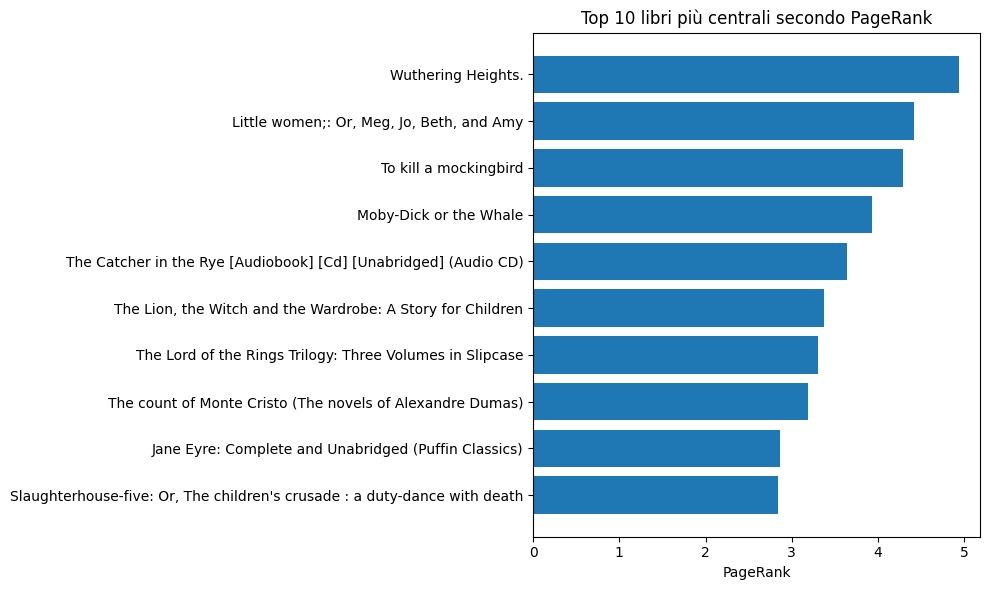

In [14]:
top_books_pd = ranked_with_info \
    .select("title", "pagerank") \
    .orderBy(col("pagerank").desc()) \
    .limit(10) \
    .toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_books_pd['title'], top_books_pd['pagerank'])
plt.xlabel("PageRank")
plt.title("Top 10 libri più centrali secondo PageRank")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
